In [1]:
import qiskit.circuit as circuit
import qiskit.pulse as pulse
import qiskit.compiler as compiler
import numpy as np
from qiskit.providers.tergite import Tergite
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging,IQXSimple

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("PinguOpenPulse_characterized")
backend.set_options(shots = 1024)

In [3]:
backend.calibration_table

,ro_dur_square,ro_amp_square,ro_tof,ro_integration_time,resonator_slope,resonator_intercept,rabi_dur_gauss,rabi_sig_gauss,rabi_frequency,qubit_frequency
qubit,,,,,,,,,,
0,0.000003,0.010,3.000000e-07,0.000003,-4.763418e+07,6.885093e+09,2.400000e-07,4.800000e-08,17.804569,5897700000
1,0.000003,0.015,3.000000e-07,0.000003,-2.865777e+07,6.745526e+09,2.400000e-07,4.800000e-08,17.804569,6109000000
2,0.000003,0.010,3.000000e-07,0.000003,-1.428770e+07,7.029714e+09,2.400000e-07,4.800000e-08,17.804569,6094000000
3,0.000003,0.015,3.000000e-07,0.000003,-8.730285e+06,7.187497e+09,2.400000e-07,4.800000e-08,17.804569,5950000000
4,0.000003,0.015,3.000000e-07,0.000003,-8.420450e+06,6.660186e+09,2.400000e-07,4.800000e-08,17.804569,5034100000


In [4]:
import rich
rich.print(backend.target.instruction_schedule_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'rx', 'delay', 'rz', 'reset'}
  q1: {'rx', 'delay', 'rz', 'reset'}
  q2: {'rx', 'delay', 'rz', 'reset'}
  q3: {'rx', 'delay', 'rz', 'reset'}
  q4: {'rx', 'delay', 'rz', 'reset'}
Multi qubit instructions:
  (0, 1, 2, 3, 4): {'measure'}
)>

In [5]:
# this chip has 5 qubits, but we will only use 4, meaning the last one will be used as ancilla
qc = circuit.QuantumCircuit(4,4)
qc.barrier([0,1,2,3])
qc.reset(1)
qc.reset(2)
qc.reset(3)
qc.h(2)
qc.h(2) # note that this is optimized away, since HH = I
qc.h(3) # this will transpile to ZXZ
qc.rx(np.pi/4, 1) # we can also do arbitrary rotations around x-axis
qc.measure([1, 2, 3], [1, 2, 3])
qc.draw()

░                            
q_0: ─░────────────────────────────
      ░      ┌─────────┐     ┌─┐   
q_1: ─░──|0>─┤ Rx(π/4) ├─────┤M├───
      ░      └──┬───┬──┘┌───┐└╥┘┌─┐
q_2: ─░──|0>────┤ H ├───┤ H ├─╫─┤M├
      ░         ├───┤   └┬─┬┘ ║ └╥┘
q_3: ─░──|0>────┤ H ├────┤M├──╫──╫─
      ░         └───┘    └╥┘  ║  ║ 
c: 4/═════════════════════╩═══╩══╩═
                          3   1  2

In [6]:
tc = compiler.transpile(qc, backend = backend)
tc.draw()

This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.
This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.
This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.
This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.


global phase: π/2
                ░                                                
      q_0 -> 0 ─░────────────────────────────────────────────────
                ░      ┌─────────┐              ┌─┐              
      q_1 -> 1 ─░──|0>─┤ Rx(π/4) ├──────────────┤M├──────────────
                ░      └─────────┘┌─┐           └╥┘              
      q_2 -> 2 ─░──|0>────────────┤M├────────────╫───────────────
                ░      ┌─────────┐└╥┘┌─────────┐ ║ ┌─────────┐┌─┐
      q_3 -> 3 ─░──|0>─┤ Rz(π/2) ├─╫─┤ Rx(π/2) ├─╫─┤ Rz(π/2) ├┤M├
                ░      └─────────┘ ║ └─────────┘ ║ └─────────┘└╥┘
ancilla_0 -> 4 ────────────────────╫─────────────╫─────────────╫─
                                   ║             ║             ║ 
          c: 4/════════════════════╩═════════════╩═════════════╩═
                                   2             1             3

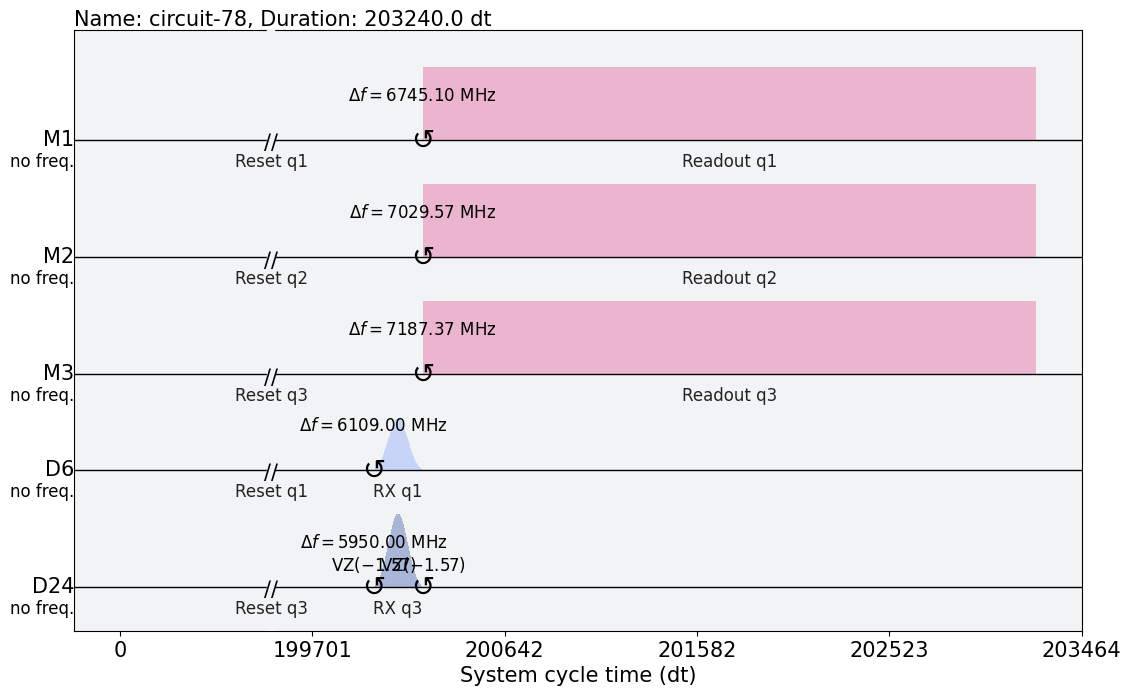

In [7]:
compiler.schedule(tc, backend = backend).draw()